### Create Pseudo-Labels using Cross-Encoder

In [1]:
import torch
import torch.nn as nn
from transformers import AutoTokenizer, AutoModel

import pandas as pd
import matplotlib.pyplot as plt

In [2]:
class CrossEncoder(nn.Module):
    def __init__(self, pretrained):
        super().__init__()
        
        # Pre-Trained LM
        self.pretrained=pretrained
        # Pooling Layer: MLP
        self.pooler=nn.Linear(pretrained.config.hidden_size, 1)
        
    def forward(self, x):
        x=self.pretrained(x)
        cls=x.last_hidden_state[:,0,:]
        return self.pooler(cls)

In [3]:
# Device: GPU
device=torch.device("cuda:0")

# Checkpoint: Distilled Cross-Encoder
tokenizer_cross=AutoTokenizer.from_pretrained("roberta-base")
cross_enc=torch.load("../model/Cross-Encoder-Distilled_batch16_lr5e-05_epoch4of5").to(device)
cross_enc.eval()
print("Loaded!")

Loaded!


### How to Make Sentence Pairs
### a. Same Pairs in Train Set

In [4]:
def pseudo_label(dataset_path, tokenizer, model):
    """
    Same Pairs in Train Set
    """
    # Read Dataset
    if "bi2cross" in dataset_path:
        df=pd.read_csv(dataset_path)
        
    # Pseudo-Labeling
    pseudo_labels=[]
    for idx in df.index:
        # Encode Sentence
        enc0=tokenizer.encode(df.loc[idx]["sent0"])
        enc1=tokenizer.encode(df.loc[idx]["sent1"])
        
        # Forward
        _input=torch.tensor([enc0[:-1]+[tokenizer.sep_token_id]+enc1[1:]])
        pred=model(_input.to(device))
        
        pseudo_labels.append(pred[0].item())
        
    # Update Column
    df["pseudo_label"]=pseudo_labels
    
    return df

In [5]:
df=pseudo_label(
    dataset_path="../dataset/bi2cross-sts-train.csv",
    tokenizer=tokenizer_cross,
    model=cross_enc
)
df.head(5)

,sent0,sent1,pseudo_label
0,A plane is taking off.,An air plane is taking off.,3.024760
1,A man is playing a large flute.,A man is playing a flute.,3.677473
2,A man is spreading shreded cheese on a pizza.,A man is spreading shredded cheese on an uncoo...,2.815390
3,Three men are playing chess.,Two men are playing chess.,2.189032
4,A man is playing the cello.,A man seated is playing the cello.,2.909889


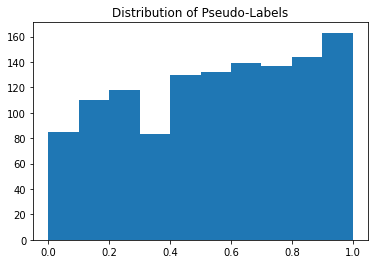

In [6]:
plt.hist(df["pseudo_label"], bins=10, range=(0,1))
plt.title("Distribution of Pseudo-Labels")
plt.show()

In [7]:
# Save Dataset
df.to_csv("../dataset/cross2bi-sts-train.csv", index=False)

### Train Bi-Encoder with Pseudo-Labels & Evaluate

In [1]:
import pandas as pd

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.cuda.amp as amp
from torch.utils.tensorboard import SummaryWriter

from transformers import AutoTokenizer, AutoModel, AdamW, get_linear_schedule_with_warmup

import numpy as np
from scipy import stats

In [2]:
# Device: GPU
device=torch.device("cuda:0")

# Hyperparams
max_sent_len=512
batch_size=16
accum_steps=1
lr=1e-7
epochs=5

In [3]:
class PseudoLabelDataset(Dataset):
    def __init__(self, path, tokenizer):
        # Data: Sentence Pair
        self.sent0=[]
        self.sent1=[]
        # Label
        self.label=[]
        
        # Read Dataset
        df=pd.read_csv(path)
        
        for idx in df.index:
            row=df.loc[idx]
            
            # Encode Sentence
            enc0=tokenizer.encode(row["sent0"], truncation=True, max_length=max_sent_len)
            enc1=tokenizer.encode(row["sent1"], truncation=True, max_length=max_sent_len)
            
            # Append Data
            self.sent0.append(enc0)
            self.sent1.append(enc1)
            # Append Label
            self.label.append(float(row["pseudo_label"]))
            
        print(len(self.sent0), "data")
            
    def __getitem__(self, idx):
        return self.sent0[idx], self.sent1[idx], self.label[idx]
    
    def __len__(self):
        return len(self.sent0)

In [4]:
def get_collate_fn(tokenizer):
    def collate_fn(batch):
        # Max Sentence Length
        max_seq_len0=0
        max_seq_len1=0
        for sent0, sent1, _ in batch:
            if len(sent0)>max_seq_len0: max_seq_len0=len(sent0)
            if len(sent1)>max_seq_len1: max_seq_len1=len(sent1)

        # Data: Sentence Pair
        batch_sent0=[]
        batch_sent1=[]
        # Label
        batch_label=[]
        for sent0, sent1, label in batch:
            sent0.extend([tokenizer.pad_token_id]*(max_seq_len0-len(sent0)))
            batch_sent0.append(sent0)
            
            sent1.extend([tokenizer.pad_token_id]*(max_seq_len1-len(sent1)))
            batch_sent1.append(sent1)

            batch_label.append(label)

        return torch.tensor(batch_sent0), torch.tensor(batch_sent1), torch.tensor(batch_label)
    
    return collate_fn

In [5]:
class BiEncoder(nn.Module):
    def __init__(self, pretrained):
        super().__init__()
        
        # Pre-Trained LM
        self.pretrained=pretrained
        # Cosine Similarity
        self.cos_sim=nn.CosineSimilarity()
        
    def forward(self, x1, x2):
        x1=self.pretrained(x1)
        hidden1=x1.last_hidden_state
        
        x2=self.pretrained(x2)
        hidden2=x2.last_hidden_state
        
        cos_sims=self.cos_sim(hidden1[:,0,:], hidden2[:,0,:]).unsqueeze(-1)
        return cos_sims

In [6]:
def train_bi_encoder_with_pseudo_labels(pseudo_label_path, loss_func):
    """
    Cross-Encoder -> Bi-Encoder Distillation
    """
    # Pre-Trained Tokenizer
    tokenizer=AutoTokenizer.from_pretrained("princeton-nlp/unsup-simcse-roberta-base")
    # Pseudo-Labeled Dataset
    dataset_train=PseudoLabelDataset(path=pseudo_label_path, tokenizer=tokenizer)
    dataloader_train=DataLoader(
        dataset_train,
        batch_size=batch_size,
        shuffle=True,
        collate_fn=get_collate_fn(tokenizer=tokenizer)
    )
    
    # Pre-Trained LM
    pretrained=AutoModel.from_pretrained("princeton-nlp/unsup-simcse-roberta-base").to(device)
    # Model: Bi-Encoder
    model=BiEncoder(pretrained=pretrained).to(device)
    model.train()
    
    # Loss: MSE
    if loss_func=="MSE":
        train_loss=nn.MSELoss()
    # Loss: BCE
    elif loss_func=="BCE":
        train_loss=nn.BCEWithLogitsLoss()
        
    # Optimizer, Scheduler
    optimizer=AdamW(model.parameters(), lr=lr)
    scheduler=get_linear_schedule_with_warmup(
        optimizer=optimizer,
        # 5% of Total Step
        num_warmup_steps=int(0.05*epochs*len(dataset_train)/(accum_steps*batch_size)),
        num_training_steps=int(epochs*len(dataset_train)/(accum_steps*batch_size))
    )

    # Mixed Precision: GradScaler
    scaler=amp.GradScaler()

    # Tensorboard
    writer=SummaryWriter()

    step_global=0
    for epoch in range(epochs):
        _loss=0
        optimizer.zero_grad()

        for step, (sent0, sent1, label) in enumerate(dataloader_train):
            # Load Data, Label
            sent0=sent0.to(device)
            sent1=sent1.to(device)
            label=label.to(device)

            # Forward
            with amp.autocast():
                pred=model(sent0, sent1)
                loss=train_loss(pred, label.unsqueeze(-1))/accum_steps
            # Backward
            scaler.scale(loss).backward()
            _loss+=loss.item()

            # Step
            if (step+1)%accum_steps==0:
                step_global+=1

                # Tensorboard
                writer.add_scalar(
                    f'loss_train/Bi-Encoder-Distilled_batch{int(accum_steps*batch_size)}_lr{lr}_epochs{epochs}',
                    _loss,
                    step_global
                )
                _loss=0

                # Optimizer, Scheduler
                scaler.step(optimizer)
                scaler.update()
                scheduler.step()
                optimizer.zero_grad()

        # Save Model
        model.to(torch.device("cpu"))
        torch.save(
            model,
            f'../model/Bi-Encoder-Distilled_batch{int(accum_steps*batch_size)}_lr{lr}_epoch{epoch+1}of{epochs}'
        )
        model.to(device)

In [7]:
def evaluate_distilled_bi_encoder(model_path):
    # Pre-Trained Tokenizer
    tokenizer=AutoTokenizer.from_pretrained("princeton-nlp/unsup-simcse-roberta-base")
    # Load Trained Model: Bi-Encoder
    model=torch.load(model_path).to(device)
    model.eval()
    
    # STS Benchmark Test Set
    with open("../dataset/stsbenchmark/sts-test.csv", "r") as f:
        stsb_test=f.read()
        f.close()

    preds=[]
    labels=[]
    for data in stsb_test.split("\n")[:-1]:
        label, sent0, sent1=data.split("\t")[4:7]
        labels.append(float(label))

        # Encode Sentence
        enc0=tokenizer.encode(sent0)
        enc1=tokenizer.encode(sent1)

        # Forward
        pred=model(torch.tensor([enc0]).to(device), torch.tensor([enc1]).to(device))

        preds.append(pred[0].item())
        
    print(np.corrcoef(preds, labels))
    print(stats.spearmanr(preds, labels))

In [8]:
# Distillation
train_bi_encoder_with_pseudo_labels(pseudo_label_path="../dataset/cross2bi-sts-train.csv", loss_func="MSE")

5749 data


/opt/conda/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [12]:
# Evaluate
evaluate_distilled_bi_encoder(model_path="../model/Bi-Encoder-Distilled_batch16_lr1e-07_epoch3of5")

[[1.         0.81442487]
 [0.81442487 1.        ]]
SpearmanrResult(correlation=0.8078585560432042, pvalue=1.8018e-318)
